## Classification on Tiny-ImageNet

fatal: destination path 'IMagenet' already exists and is not an empty directory.
starting loading data
finished loading data, in 27.347519397735596 seconds


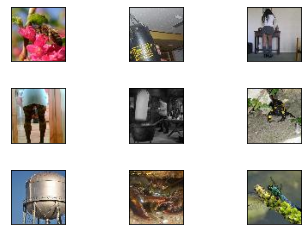

In [ ]:
from keras import backend as K
import scipy.ndimage as nd
from keras.models import Sequential,load_model
from keras import regularizers
from keras import initializers
from keras import metrics
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Convolution2D, MaxPooling2D, BatchNormalization, ReLU, LeakyReLU
from keras import layers
from keras import models
from keras.optimizers import Adam
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os
import time
import cv2
import matplotlib.pyplot as plt

# download TinyImageNet
! git clone https://github.com/seshuad/IMagenet

def get_id_dictionary():
    id_dict = {}
    for i, line in enumerate(open('IMagenet/tiny-imagenet-200/wnids.txt', 'r')):
        id_dict[line.replace('\n', '')] = i
    return id_dict

def get_class_to_id_dict():
    id_dict = get_id_dictionary()
    all_classes = {}
    result = {}
    for i, line in enumerate(open('IMagenet/tiny-imagenet-200/words.txt', 'r')):
        n_id, word = line.split('\t')[:2]
        all_classes[n_id] = word
    for key, value in id_dict.items():
        result[value] = (key, all_classes[key])

    return result

def get_data(id_dict):

    print('starting loading data')
    train_data, val_data, test_data = [], [], []
    train_labels, val_labels, test_labels = [], [], []
    t = time.time()
    for key, value in id_dict.items():
        train_data += [cv2.imread('IMagenet/tiny-imagenet-200/train/{}/images/{}_{}.JPEG'.format(key, key, str(i))) for i in range(450)]

        train_labels_ = np.array([[0]*200]*450)
        train_labels_[:, value] = 1
        train_labels += train_labels_.tolist()

        val_data += [cv2.imread('IMagenet/tiny-imagenet-200/train/{}/images/{}_{}.JPEG'.format(key, key, str(i))) for i in range(450, 500)]

        val_labels_ = np.array([[0]*200]*50)
        val_labels_[:, value] = 1
        val_labels += val_labels_.tolist()

    for line in open('IMagenet/tiny-imagenet-200/val/val_annotations.txt'):
        img_name, class_id = line.split('\t')[:2]
        test_data.append(cv2.imread('IMagenet/tiny-imagenet-200/val/images/{}'.format(img_name)))

        test_labels_ = np.array([[0]*200])
        test_labels_[0, id_dict[class_id]] = 1
        test_labels += test_labels_.tolist()

    print('finished loading data, in {} seconds'.format(time.time() - t))

    return np.array(train_data), np.array(train_labels), np.array(val_data), np.array(val_labels), np.array(test_data), np.array(test_labels)

def shuffle_data(train_data, train_labels, val_data, val_labels):
    # This function shuffles separately the train set and the
    # validation set
    size = len(train_data)
    train_idx = np.arange(size)
    np.random.shuffle(train_idx)

    size = len(val_data)
    val_idx = np.arange(size)
    np.random.shuffle(val_idx)

    return train_data[train_idx], train_labels[train_idx], val_data[val_idx], val_labels[val_idx]

train_data, train_labels, val_data, val_labels, test_data, test_labels = get_data(get_id_dictionary())
train_data, train_labels, val_data, val_labels = shuffle_data(train_data, train_labels, val_data, val_labels)

# visualise
N=3
start_val = 0 # pick an element for the code to plot the following N**2 values
fig, axes = plt.subplots(N,N)
for row in range(N):
  for col in range(N):
    idx = start_val+row+N*col
    tmp = cv2.cvtColor(train_data[idx],cv2.COLOR_BGR2RGB)
    axes[row,col].imshow(tmp, cmap='gray')
    fig.subplots_adjust(hspace=0.5)
    axes[row,col].set_xticks([])
    axes[row,col].set_yticks([])

train_data = train_data.astype('float32') / 255.
val_data = val_data.astype('float32') / 255.
test_data = test_data.astype('float32') / 255.

mean = np.mean(train_data,axis=(0,1,2,3))
std = np.std(train_data, axis=(0, 1, 2, 3))
train_data = (train_data-mean)/(std+1e-7)
val_data = (val_data-mean)/(std+1e-7)
test_data = (test_data-mean)/(std+1e-7)

In [ ]:
# Transform the training data into a keras dataset for better memory efficiency
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
del train_data
del train_labels

In [ ]:
# Imports
from keras.applications.vgg16 import VGG16
from keras.applications import ResNet50V2
from keras.models import Model
from keras.layers import Dense, Flatten
from keras.callbacks import EarlyStopping

## VGG16 trained from scratch

In [ ]:
# Define the model for 64x64x3 input to train from scratch
model = VGG16(weights=None, include_top=False, input_shape=(64, 64, 3))
output = model.output
output = Flatten()(output)
output = Dense(units=4096, activation='relu')(output)
output = Dense(units=4096, activation='relu')(output)
output = Dense(units=200, activation='softmax')(output)
model = Model(model.input, output)
early_stopping = EarlyStopping(monitor='val_categorical_accuracy', patience=4, restore_best_weights=True)
# Train the model
model.compile(optimizer=Adam(learning_rate=1e-4),loss='categorical_crossentropy', metrics=['categorical_accuracy'])
history = model.fit(train_dataset.batch(32), epochs=20, validation_data=(val_data, val_labels), callbacks=[early_stopping])
# Evaluate the model
start_time = time.time()
score = model.evaluate(test_data, test_labels)
time_elapsed = time.time() - start_time
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print('Average inference time per image: {:.4f} (ms)'.format(1000*time_elapsed/len(test_data)))

NameError: ignored

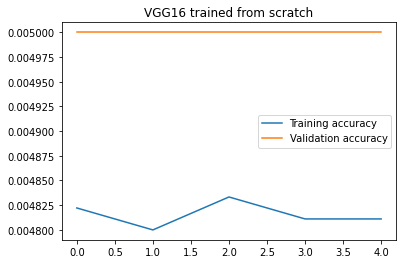

In [ ]:
# Plot the training and validation accuracy curves
plt.plot(history.history['categorical_accuracy'], label='Training accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Validation accuracy')
plt.title('VGG16 trained from scratch')
plt.legend()
plt.show()

## Transfer Learning VGG16

In [ ]:
# Define the model with pre-trained weights for 64x64x3 input to train only the top layers
model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
for layer in model.layers[:]:
    layer.trainable = False
output = model.output
output = Flatten()(output)
output = Dense(units=4096, activation='relu')(output)
output = Dense(units=4096, activation='relu')(output)
output = Dense(units=200, activation='softmax')(output)
model = Model(model.input, output)
early_stopping = EarlyStopping(monitor='val_categorical_accuracy', patience=4, restore_best_weights=True)
# Train the model
model.compile(optimizer=Adam(learning_rate=1e-4),loss='categorical_crossentropy', metrics=['categorical_accuracy'])
history = model.fit(train_dataset.batch(32), epochs=20, validation_data=(val_data, val_labels), callbacks=[early_stopping])
# Evaluate the model
start_time = time.time()
score = model.evaluate(test_data, test_labels)
time_elapsed = time.time() - start_time
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print('Average inference time per image: {:.4f} (ms)'.format(1000*time_elapsed/len(test_data)))

Epoch 1/20
2813/2813 [==============================] - 76s 24ms/step - loss: 2.7065 - categorical_accuracy: 0.3675 - val_loss: 2.3128 - val_categorical_accuracy: 0.4331
Epoch 2/20
2813/2813 [==============================] - 66s 23ms/step - loss: 1.8557 - categorical_accuracy: 0.5343 - val_loss: 2.2519 - val_categorical_accuracy: 0.4540
Epoch 3/20
2813/2813 [==============================] - 65s 23ms/step - loss: 1.2918 - categorical_accuracy: 0.6726 - val_loss: 2.3164 - val_categorical_accuracy: 0.4568
Epoch 4/20
2813/2813 [==============================] - 64s 23ms/step - loss: 0.7806 - categorical_accuracy: 0.8101 - val_loss: 2.5110 - val_categorical_accuracy: 0.4507
Epoch 5/20
2813/2813 [==============================] - 65s 23ms/step - loss: 0.4084 - categorical_accuracy: 0.9106 - val_loss: 2.8460 - val_categorical_accuracy: 0.4436
Epoch 6/20
2813/2813 [==============================] - 64s 23ms/step - loss: 0.2324 - categorical_accuracy: 0.9508 - val_loss: 3.1305 - val_categoric

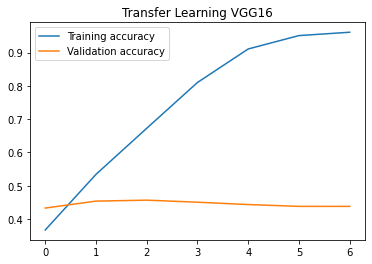

In [ ]:
# Plot the training and validation accuracy curves
plt.plot(history.history['categorical_accuracy'], label='Training accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Validation accuracy')
plt.title('Transfer Learning VGG16')
plt.legend()
plt.show()

## Fine-tuning VGG16

In [ ]:
# Define the model with pre-trained weights for 64x64x3 input
model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
output = model.output
output = Flatten()(output)
output = Dense(units=4096, activation='relu')(output)
output = Dense(units=4096, activation='relu')(output)
output = Dense(units=200, activation='softmax')(output)
model = Model(model.input, output)
early_stopping = EarlyStopping(monitor='val_categorical_accuracy', patience=4, restore_best_weights=True)
# Train the model
model.compile(optimizer=Adam(learning_rate=1e-4),loss='categorical_crossentropy', metrics=['categorical_accuracy'])
history = model.fit(train_dataset.batch(32), epochs=20, validation_data=(val_data, val_labels), callbacks=[early_stopping])
# Evaluate the model
start_time = time.time()
score = model.evaluate(test_data, test_labels)
time_elapsed = time.time() - start_time
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print('Average inference time per image: {:.4f} (ms)'.format(1000*time_elapsed/len(test_data)))

Epoch 1/20
2813/2813 [==============================] - 166s 55ms/step - loss: 5.2987 - categorical_accuracy: 0.0043 - val_loss: 5.2983 - val_categorical_accuracy: 0.0050
Epoch 2/20
2813/2813 [==============================] - 153s 54ms/step - loss: 5.2985 - categorical_accuracy: 0.0042 - val_loss: 5.2983 - val_categorical_accuracy: 0.0050
Epoch 3/20
2813/2813 [==============================] - 154s 55ms/step - loss: 5.2985 - categorical_accuracy: 0.0041 - val_loss: 5.2983 - val_categorical_accuracy: 0.0050
Epoch 4/20
2813/2813 [==============================] - 152s 54ms/step - loss: 5.2985 - categorical_accuracy: 0.0042 - val_loss: 5.2983 - val_categorical_accuracy: 0.0050
Epoch 5/20
313/313 [==============================] - 5s 16ms/step - loss: 5.2983 - categorical_accuracy: 0.0050
Test loss: 5.298316955566406
Test accuracy: 0.004999999888241291
Average inference time per image: 0.5995 (ms)


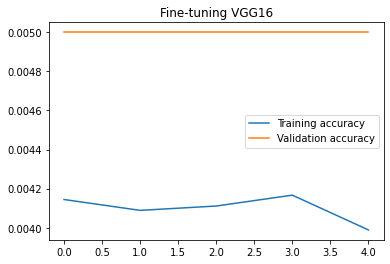

In [ ]:
# Plot the training and validation accuracy curves
plt.plot(history.history['categorical_accuracy'], label='Training accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Validation accuracy')
plt.title('Fine-tuning VGG16')
plt.legend()
plt.show()

## Transfer Learning ResNet50V2

In [ ]:
# Define the model with pre-trained weights for 64x64x3 input to train only the top layers
model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(64, 64, 3), pooling='avg')
for layer in model.layers[:]:
    layer.trainable = False
# Redefine the top layer
output = model.output
output = Dense(units=200, activation='softmax')(output)
model = Model(model.input, output)
early_stopping = EarlyStopping(monitor='val_categorical_accuracy', patience=4, restore_best_weights=True)
# Train the model
model.compile(optimizer=Adam(learning_rate=1e-4),loss='categorical_crossentropy', metrics=['categorical_accuracy'])
history = model.fit(train_dataset.batch(32), epochs=20, validation_data=(val_data, val_labels), callbacks=[early_stopping])
# Evaluate the model
start_time = time.time()
score = model.evaluate(test_data, test_labels)
time_elapsed = time.time() - start_time
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print('Average inference time per image: {:.4f} (ms)'.format(1000*time_elapsed/len(test_data)))

Epoch 1/20
2813/2813 [==============================] - 64s 19ms/step - loss: 5.1949 - categorical_accuracy: 0.0982 - val_loss: 4.3042 - val_categorical_accuracy: 0.1629
Epoch 2/20
2813/2813 [==============================] - 50s 18ms/step - loss: 3.8404 - categorical_accuracy: 0.2108 - val_loss: 3.9699 - val_categorical_accuracy: 0.2005
Epoch 3/20
2813/2813 [==============================] - 50s 18ms/step - loss: 3.4002 - categorical_accuracy: 0.2678 - val_loss: 3.8364 - val_categorical_accuracy: 0.2215
Epoch 4/20
2813/2813 [==============================] - 51s 18ms/step - loss: 3.1173 - categorical_accuracy: 0.3087 - val_loss: 3.7722 - val_categorical_accuracy: 0.2315
Epoch 5/20
2813/2813 [==============================] - 51s 18ms/step - loss: 2.9087 - categorical_accuracy: 0.3423 - val_loss: 3.7416 - val_categorical_accuracy: 0.2377
Epoch 6/20
2813/2813 [==============================] - 49s 18ms/step - loss: 2.7443 - categorical_accuracy: 0.3724 - val_loss: 3.7306 - val_categoric

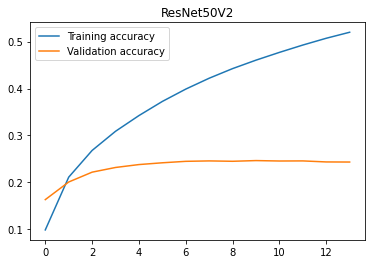

In [ ]:
# Plot the training and validation accuracy curves
plt.plot(history.history['categorical_accuracy'], label='Training accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Validation accuracy')
plt.title('ResNet50V2')
plt.legend()
plt.show()

In [ ]:
from keras.callbacks import EarlyStopping

# model

early_stopping = EarlyStopping(monitor='val_categorical_accuracy', patience=4, restore_best_weights=True)

model.compile(optimizer=Adam(lr=1e-4),loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.fit(train_data, train_labels, epochs=20, batch_size=128, validation_data=(val_data, val_labels), callbacks=[early_stopping])

start_time = time.time()
score = model.evaluate(test_data, test_labels)
time_elapsed = time.time() - start_time
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print('Average inference time per image: {:.4f} (ms)'.format(1000*time_elapsed/len(test_data)))